# Ideal Parameter Analysis ($\delta=2.25$, $\tau=0.75$, $\alpha=2$) ($\tau$ step down)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=0.75
expected_alpha=2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

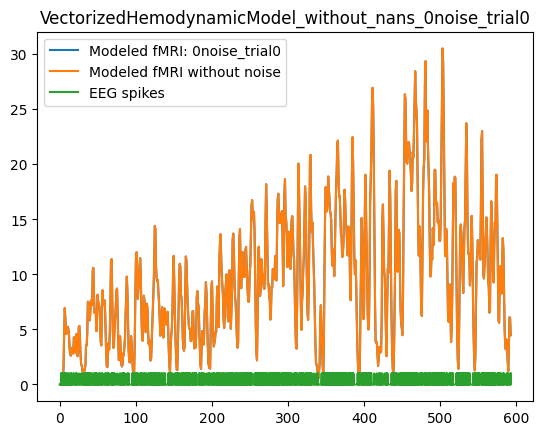

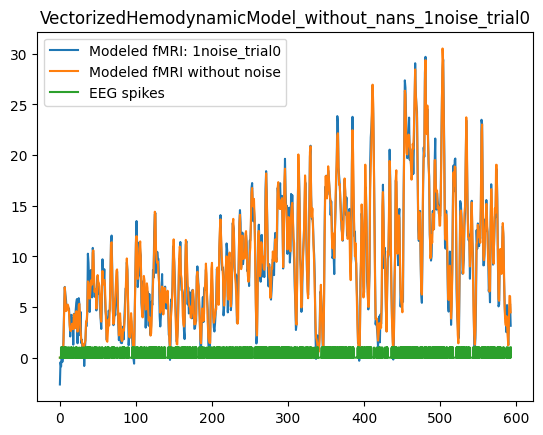

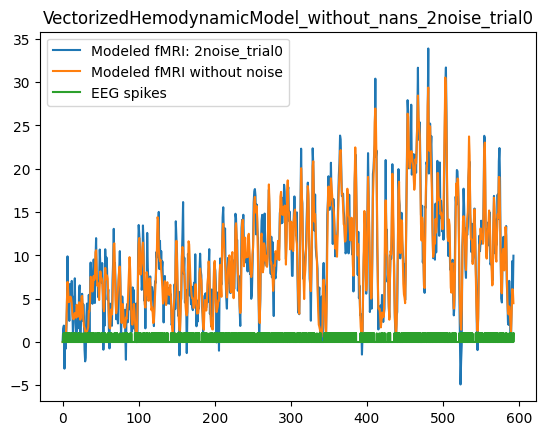

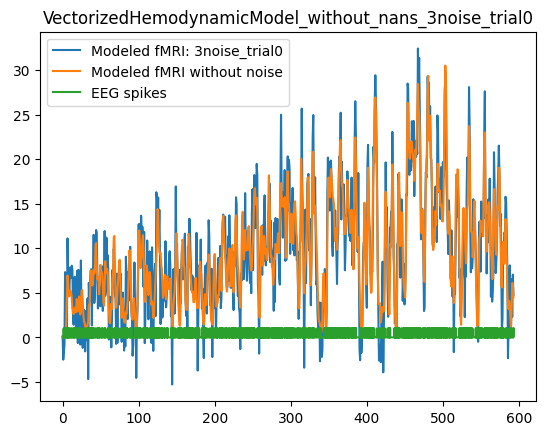

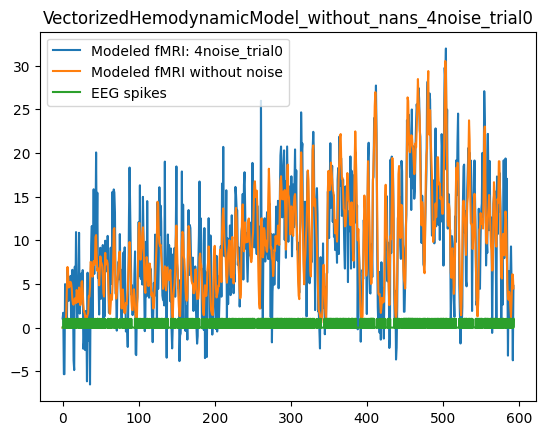

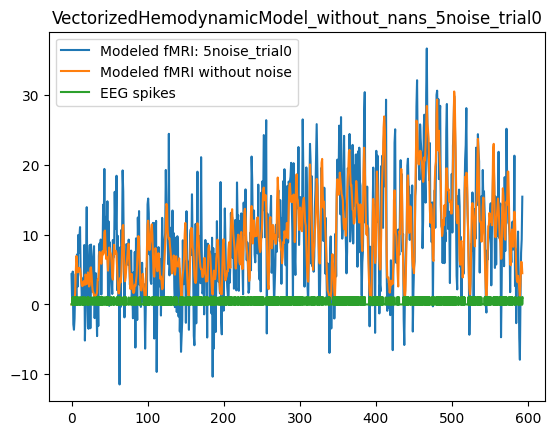

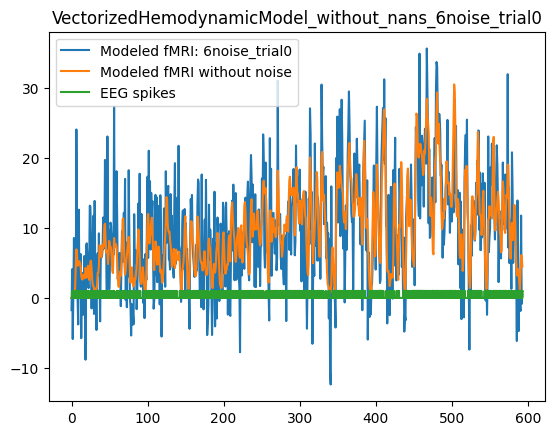

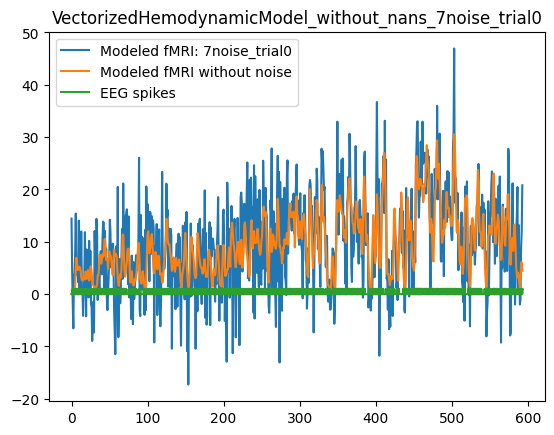

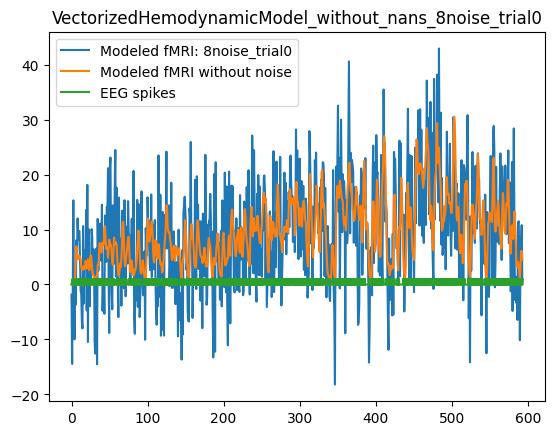

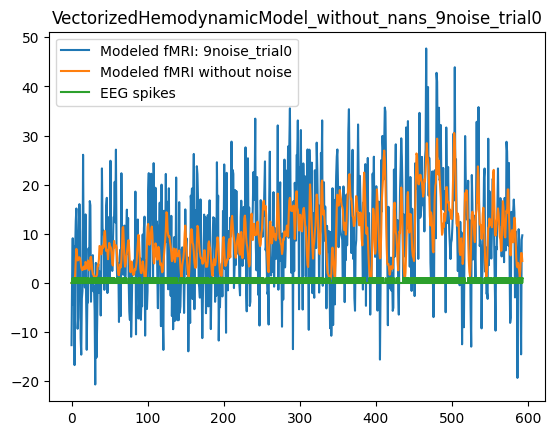

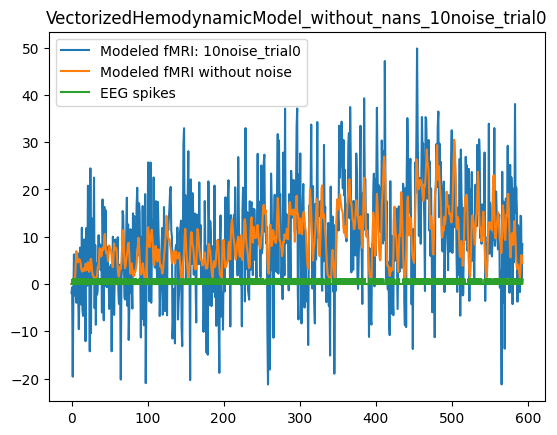

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 0.75, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=0.75, alpha=2


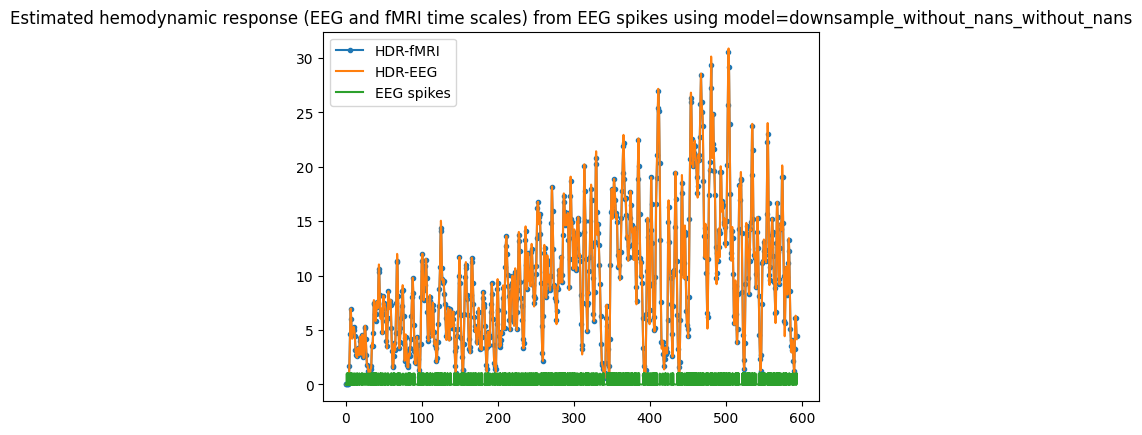

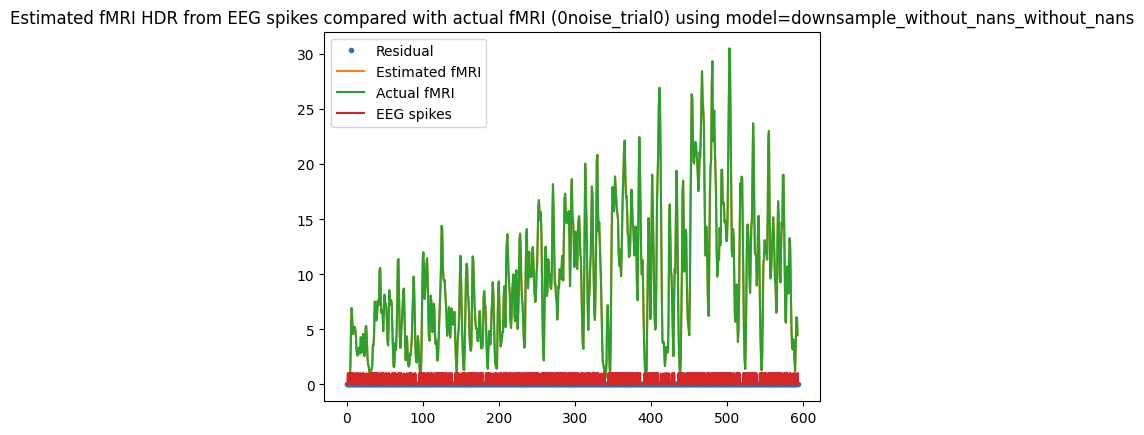

Residual Variance is 0.000000


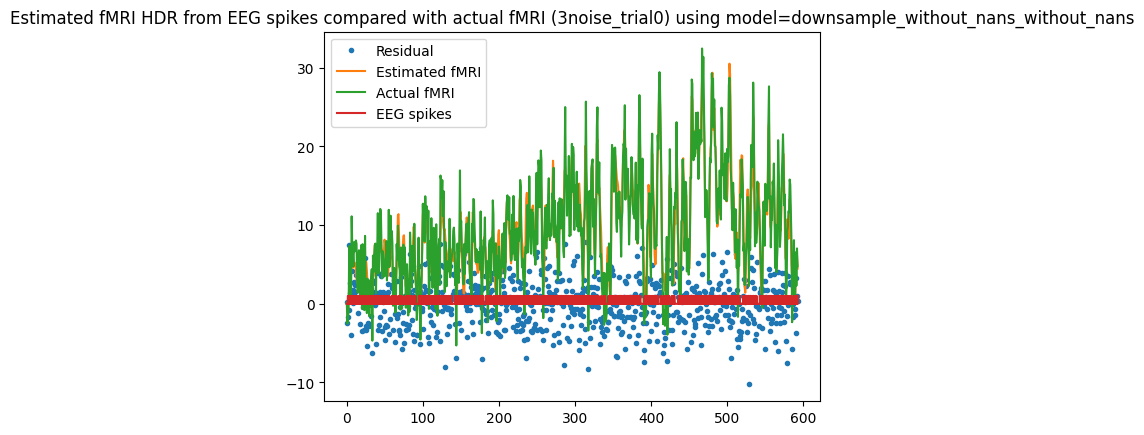

Residual Variance is 8.998642


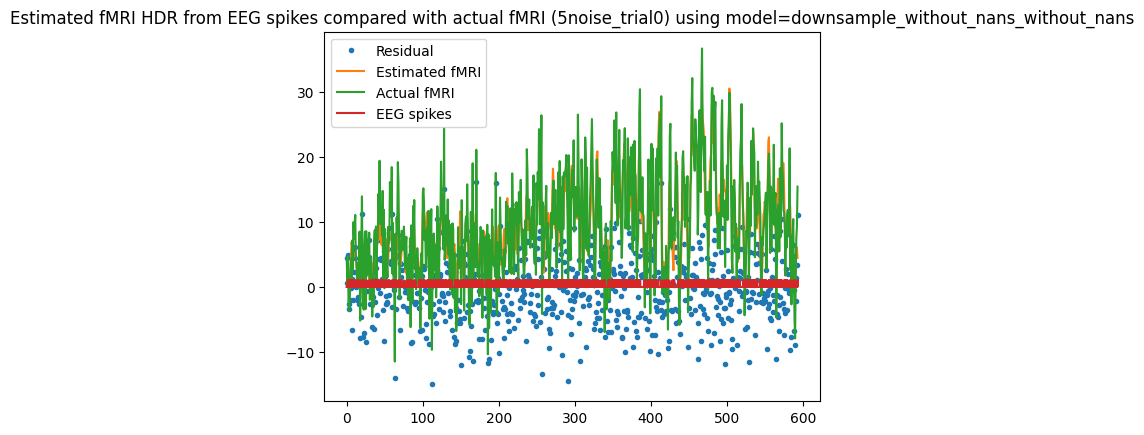

Residual Variance is 25.998133


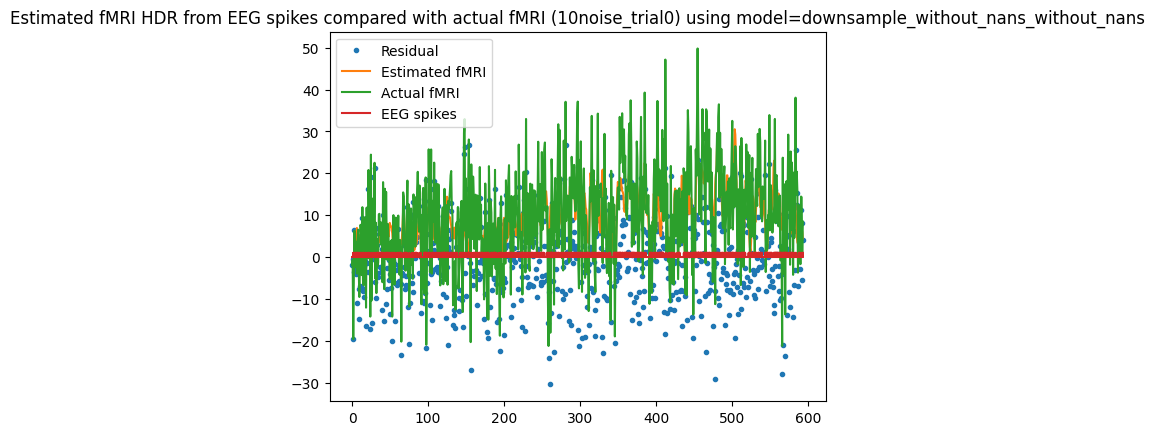

Residual Variance is 97.651860


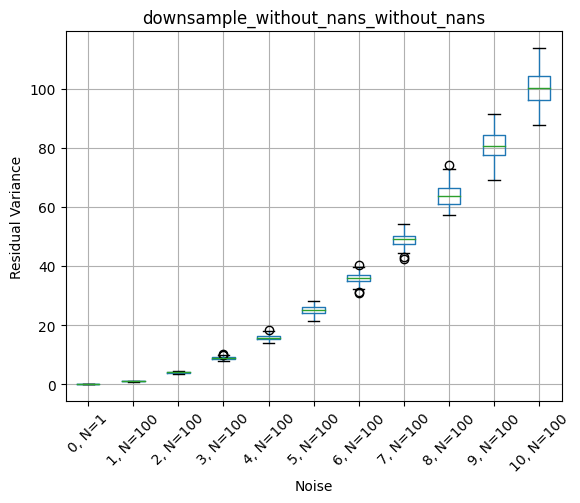

Scoring downsample_without_nans_with_nans delta=2.25, tau=0.75, alpha=2


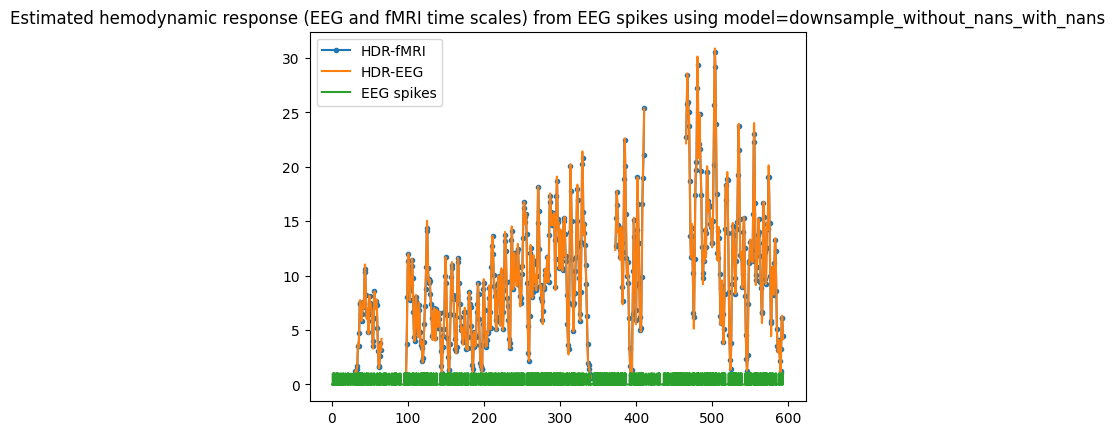

Residual Variance is 0.000000


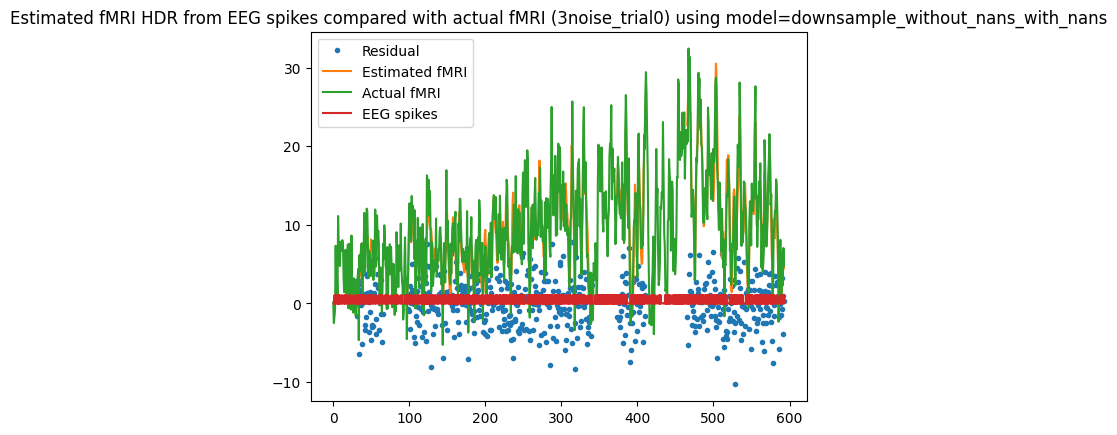

Residual Variance is 9.032400


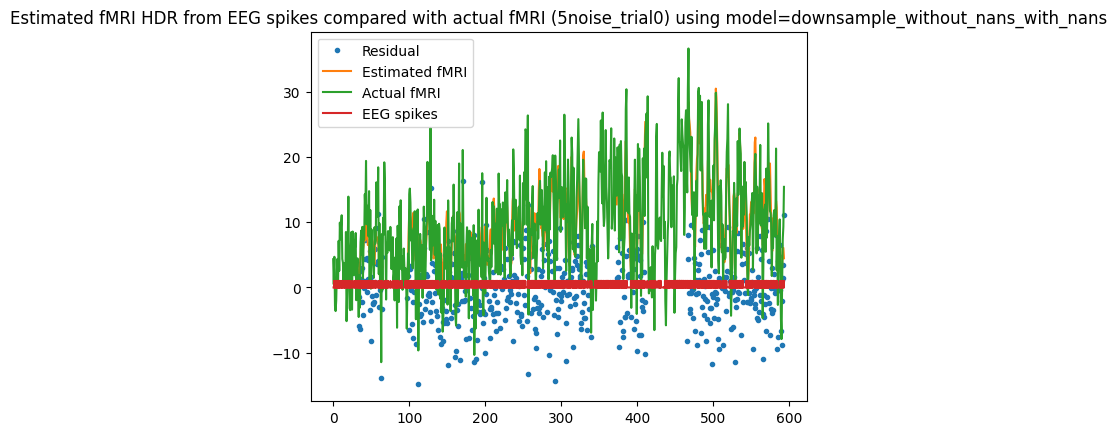

Residual Variance is 26.723825


Residual Variance is 97.171268


In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans  14.662609298873212   
1         downsample_without_nans_with_nans  14.405014165581532   
2      downsample_without_nans_without_nans  14.098613506424288   
3         downsample_without_nans_with_nans   13.87589079805324   
4      downsample_without_nans_without_nans  13.537676757646999   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  18.699787641893305   
18938  downsample_without_nans_without_nans   20.12357934094029   
18939     downsample_without_nans_with_nans   18.98188502516939   
18940  downsample_without_nans_without_nans  20.438661146764556   
18941     downsample_without_nans_with_nans   19.25092849862448   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      15.676549254955907  18.504334396362385  23.555421206207008   
1      15.321300073512747  18.266213856020922  23.291873011297223   
2      15.118625224780764  17.937468765184356  22.985293792185562   
3      14.800116853990739  17.738805049138673  22.759764228127843   
4      14.563614484657881  17.373838950141383  22.418517047387336   
...                   ...                 ...                 ...   
18937  19.868464143517155   23.00549477484672  28.770828031386618   
18938   21.40914195735891  24.382289025128905  30.680620337649984   
18939   20.15131555884101   23.28407473924444   29.06429744710473   
18940   21.72954825878302  24.694538365903767  31.006685356889303   
18941  20.420831562241887    23.5494390804753  29.344158618445757   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0      29.204080820160282  41.342551360732315  ...  15.327738467285828   
1       29.87842111173663   41.94165494999485  ...  14.901338919812599   
2       28.68003135606282  40.757792286576745  ...  14.772721862361772   
3      29.381968109952695  41.385678912409766  ...  14.383155020703853   
4       28.15911201608372   40.17504064216581  ...  14.220833018947557   
...                   ...                 ...  ...                 ...   
18937   33.39099463164253   45.23644672531215  ...   19.25295479894041   
18938   34.05069030551151      46.31834309458  ...  20.796770166862135   
18939   33.65325527064323   45.52473048449957  ...  19.526814681874676   
18940   34.33891498375879   46.65709019794826  ...  21.108233491375973   
18941   33.90376462834891  45.799950742056005  ...  19.787747393789157   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       18.41338155198898   25.09644461599785  32.538889086474136   
1      18.580834617311933   25.71960848654023   32.57372409007334   
2       17.87796931358186   24.51262365669533   31.97104103540752   
3      18.069211906310482   25.15921696042318  32.034474753914374   
4      17.344933208938677   23.93062262827571  31.404061263991533   
...                   ...                 ...                 ...   
18937   21.87893961478643  30.267502273843878  35.583503576900554   
18938  23.026768720999502  31.191633089567446  37.036056687226555   
18939  22.161455491032783  30.592824637774243  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.0926410729936034e-28; at
       delta   tau  alpha
11560   2.25  0.75    2.0


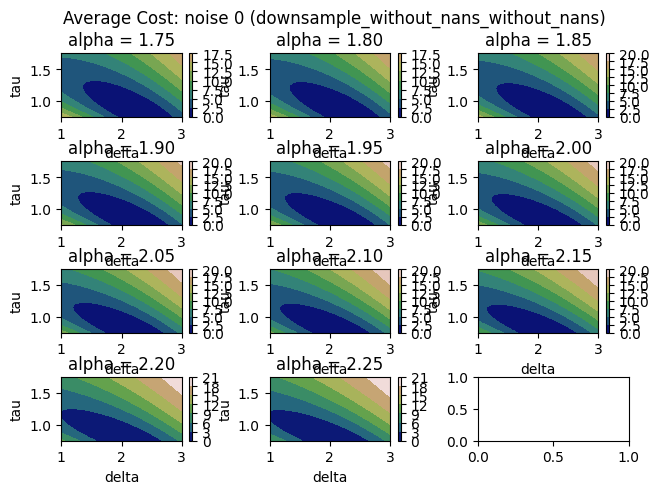

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              14.662609             
2                                              14.098614             
4                                              13.537677             
6                                              12.980677             
8                                              12.428489             
...                                                  ...             
18932                                          19.098574             
18934                                          19.453825             
18936                                          19.795400             
18938                                          20.123579             
18940                                          20.438661             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.75, Alpha target: 2


delta   tau  alpha
0   2.25  0.75    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  1.092641e-28   2.25  0.75    2.0
1      0         0  5.145125e-03   2.30  0.80    1.8

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         2.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration          cost  delta   tau  alpha
0      0         0  1.092641e-28   2.25  0.75    2.0

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 6.953956434315052e-29; at
       delta   tau  alpha
11561   2.25  0.75    2.0


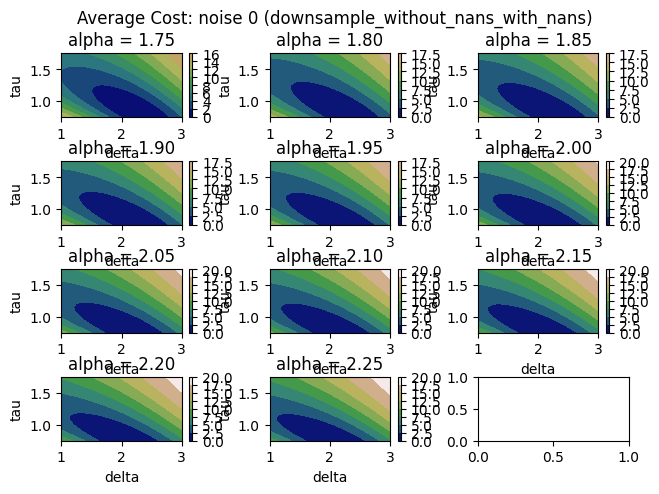

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              14.405014          
3                                              13.875891          
5                                              13.347783          
7                                              12.821563          
9                                              12.298106          
...                                                  ...          
18933                                          18.094920          
18935                                          18.404255          
18937                                          18.699788          
18939                                          18.981885          
18941                                          19.250928          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 0.75, Alpha target: 2


delta   tau  alpha
0   2.25  0.75    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 0.75, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  6.953956e-29   2.25  0.75    2.0
1      0         0  4.828074e-03   2.30  0.80    1.8

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         2.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration          cost  delta   tau  alpha
0      0         0  6.953956e-29   2.25  0.75    2.0

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9976581749135466; at
       delta   tau  alpha
11560   2.25  0.75    2.0


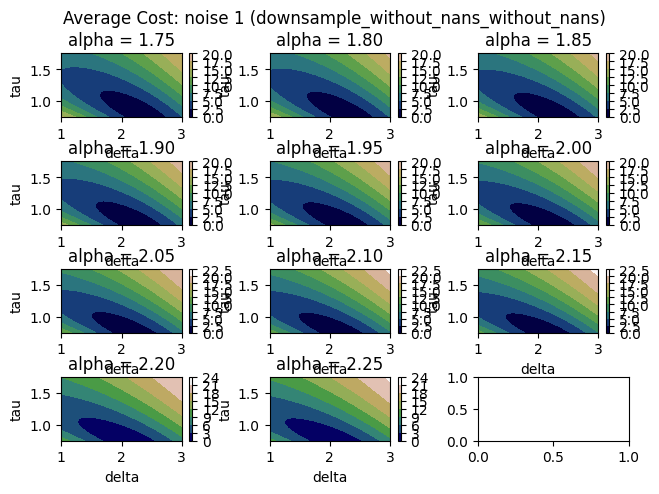

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.998209627765896; at
       delta   tau  alpha
11560   2.25  0.75    2.0


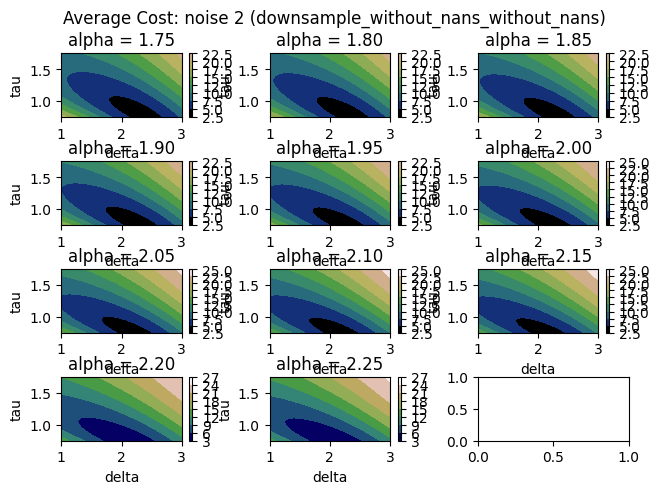

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.976240396739426; at
       delta   tau  alpha
11560   2.25  0.75    2.0


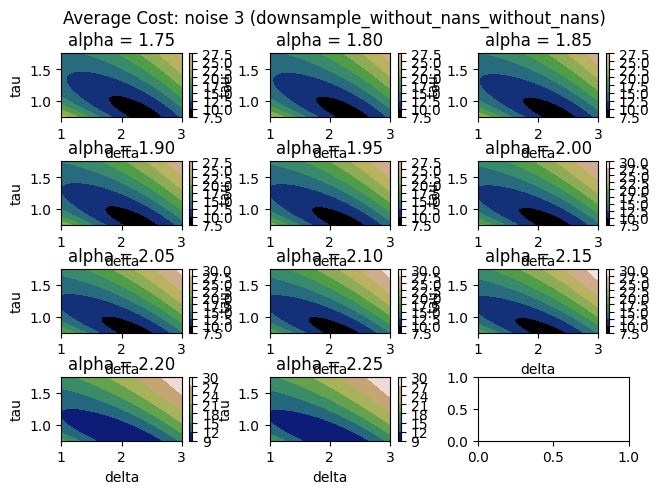

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.756918619516576; at
       delta   tau  alpha
11560   2.25  0.75    2.0


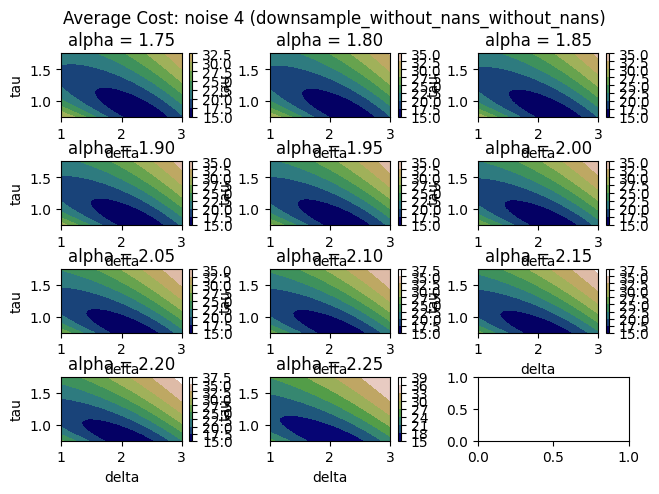

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.956388350750487; at
       delta   tau  alpha
11560   2.25  0.75    2.0


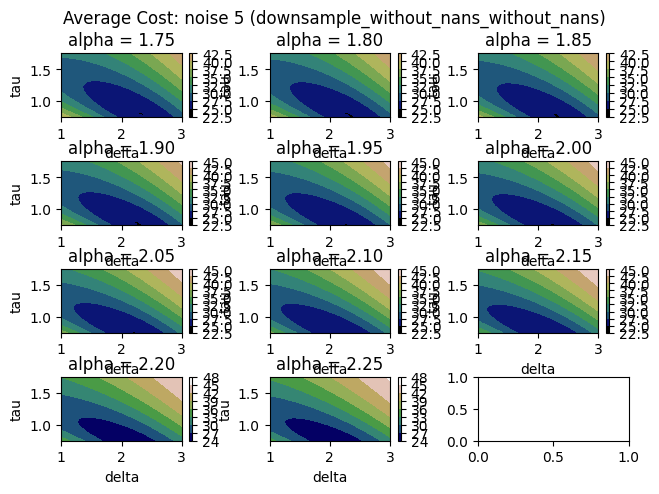

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.87853244691792; at
       delta   tau  alpha
11560   2.25  0.75    2.0


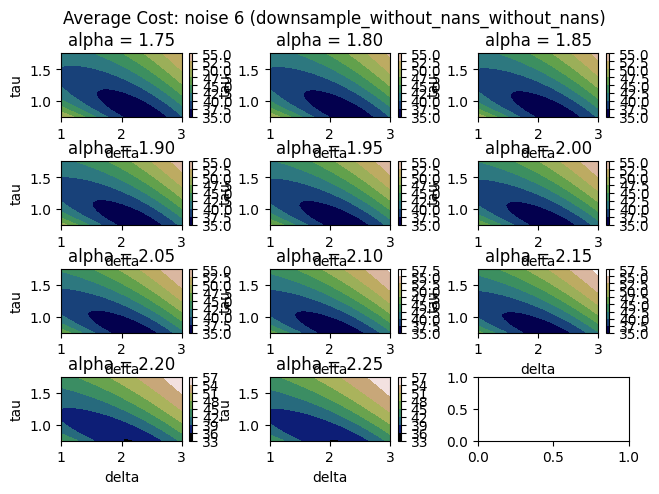

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.946399477787985; at
       delta   tau  alpha
12020    2.3  0.75   1.95


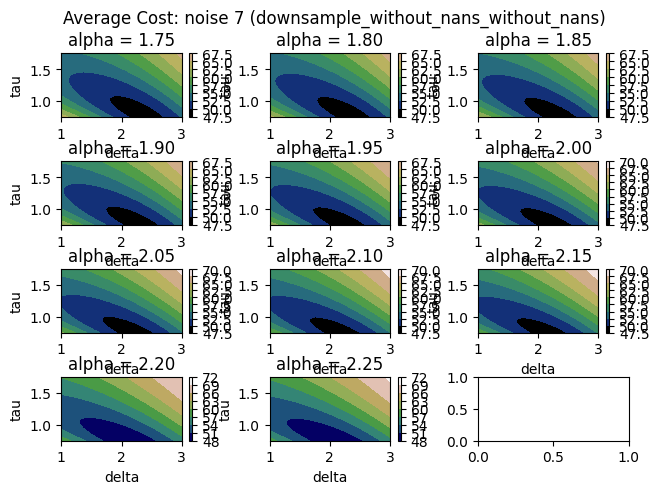

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.808357916463265; at
       delta   tau  alpha
11560   2.25  0.75    2.0


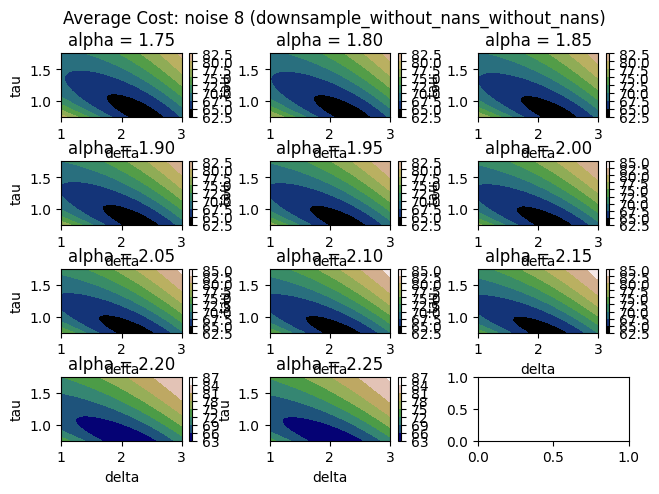

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.94546120040701; at
       delta   tau  alpha
11100    2.2  0.75   2.05


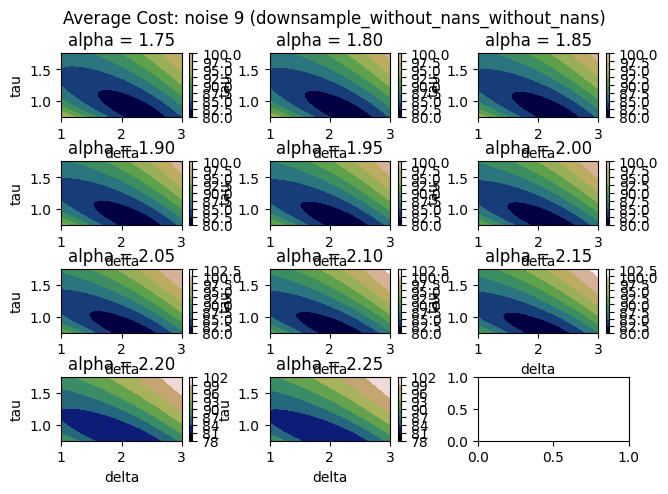

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.99606166192639; at
       delta   tau  alpha
11560   2.25  0.75    2.0


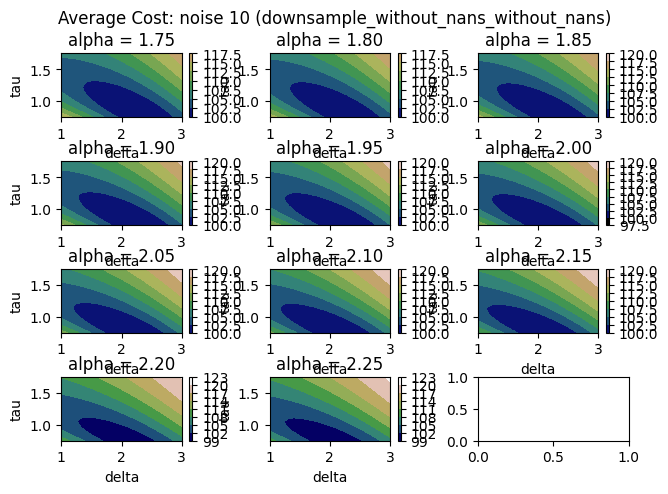

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

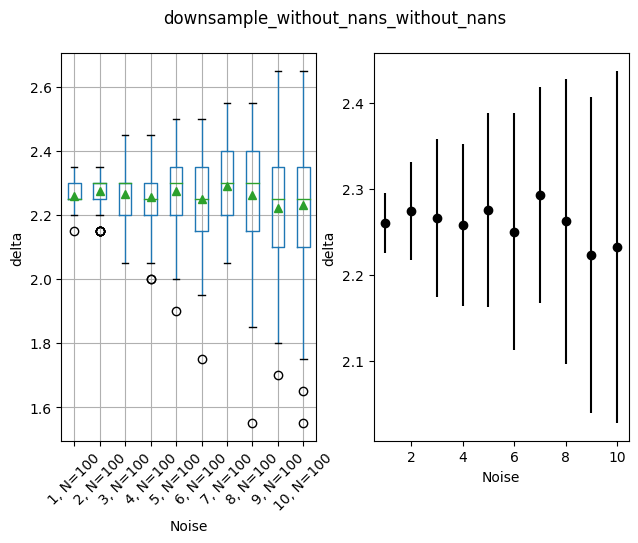

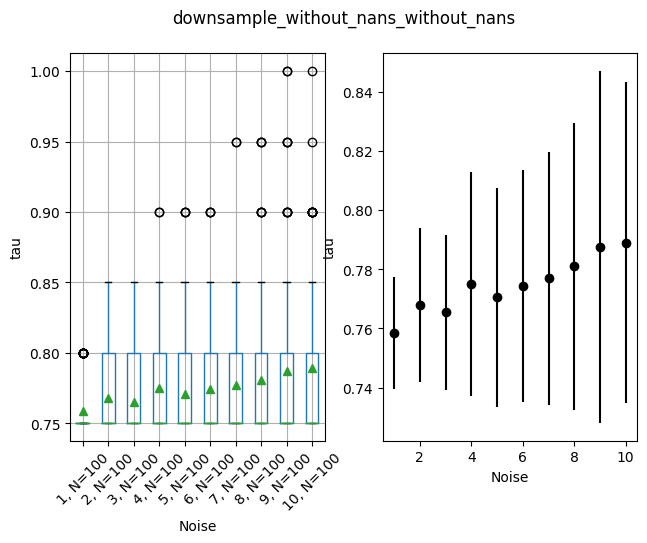

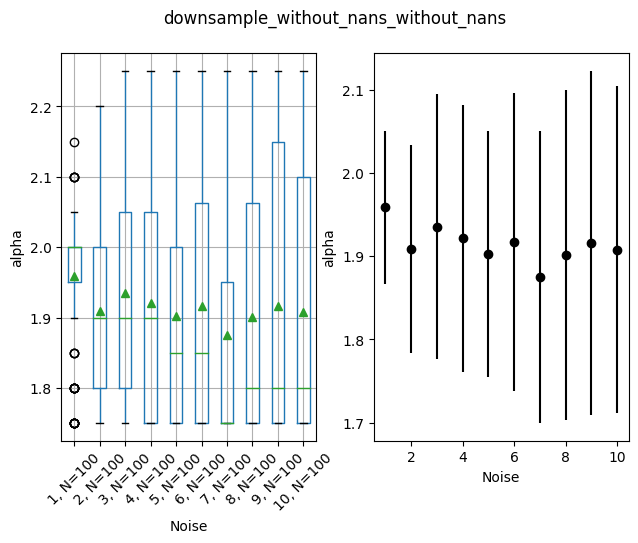

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9987827066590349; at
       delta   tau  alpha
11561   2.25  0.75    2.0


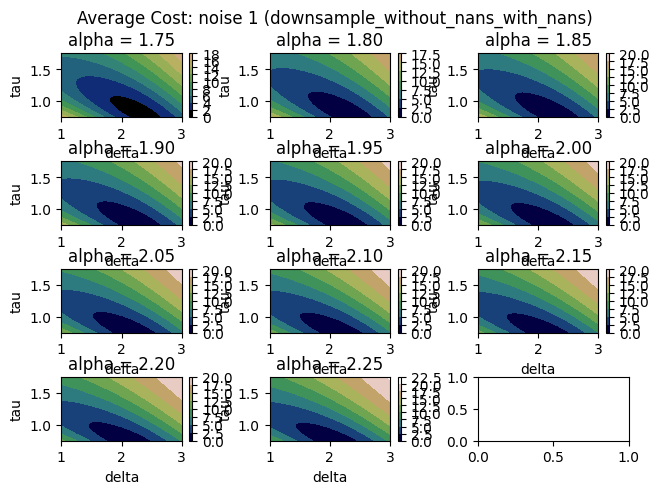

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.021295380391262; at
       delta   tau  alpha
11561   2.25  0.75    2.0


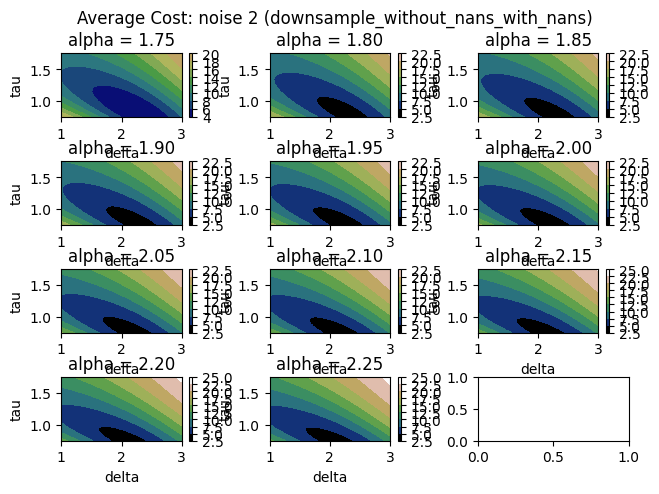

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.051024956694448; at
       delta   tau  alpha
11561   2.25  0.75    2.0


Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.751838587752939; at
       delta   tau  alpha
11561   2.25  0.75    2.0


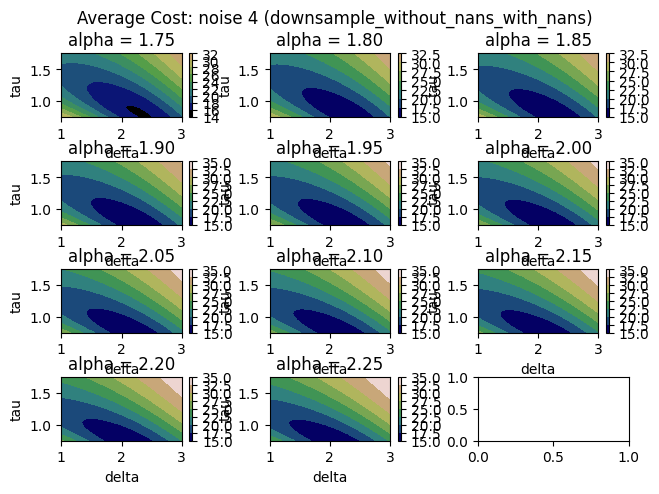

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.973596706447417; at
       delta   tau  alpha
11561   2.25  0.75    2.0


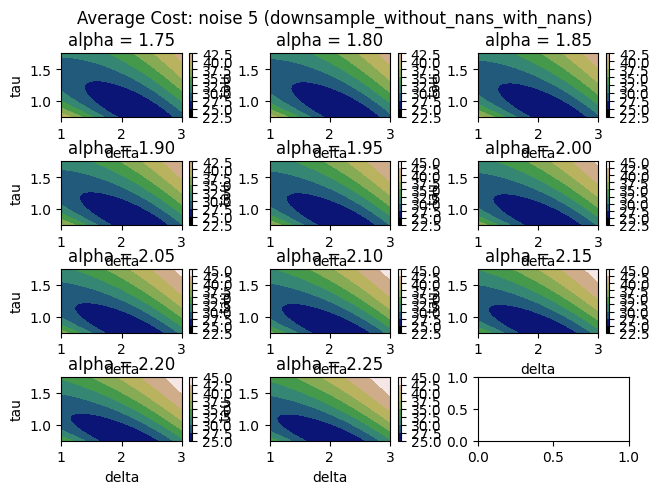

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.69639109623484; at
       delta   tau  alpha
11561   2.25  0.75    2.0


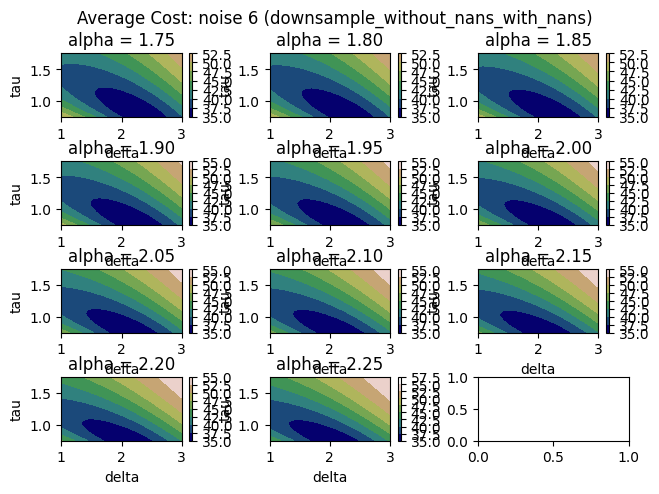

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.0799620730154; at
       delta  tau  alpha
12497   2.35  0.8   1.75


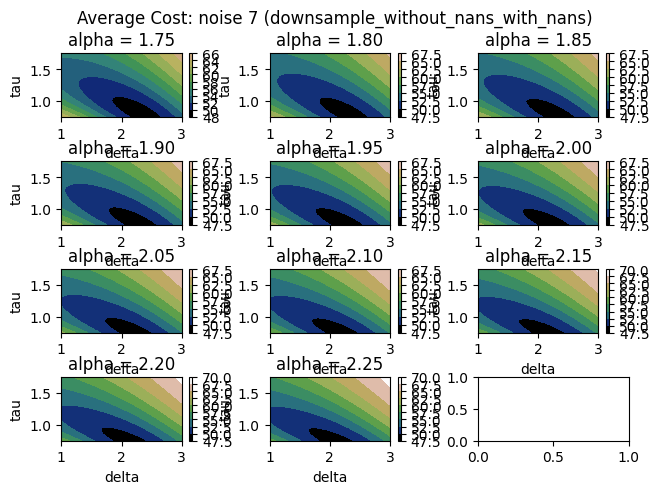

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.77283192619744; at
       delta   tau  alpha
11561   2.25  0.75    2.0


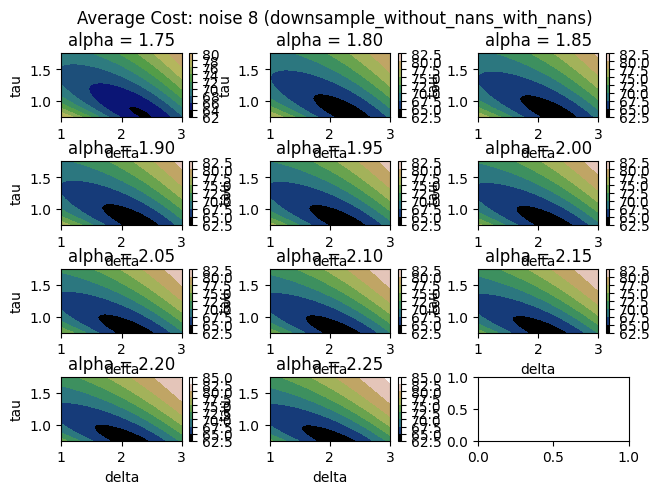

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.9618280641827; at
       delta   tau  alpha
11101    2.2  0.75   2.05


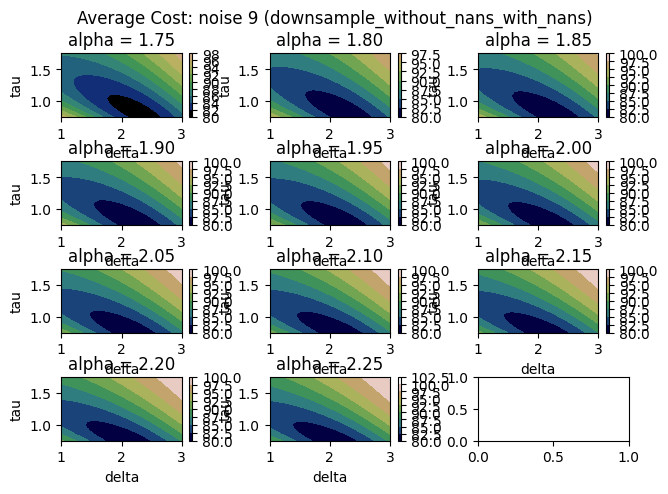

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.97506950616433; at
       delta   tau  alpha
11561   2.25  0.75    2.0


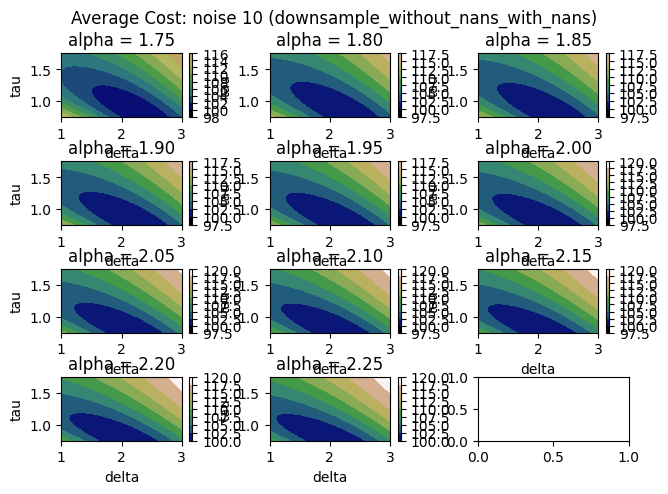

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


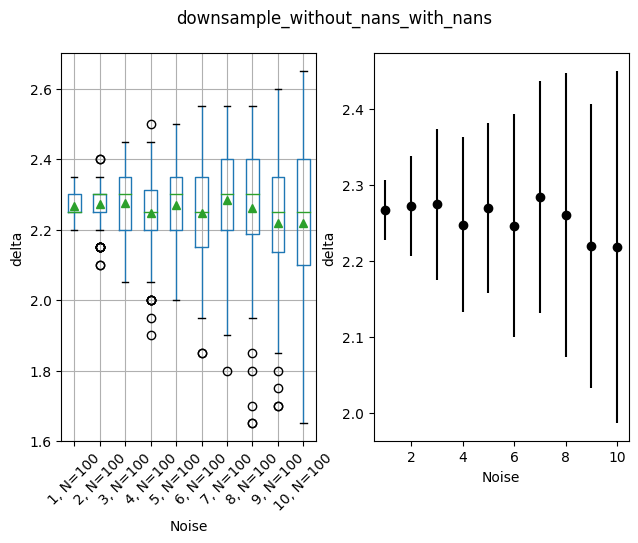

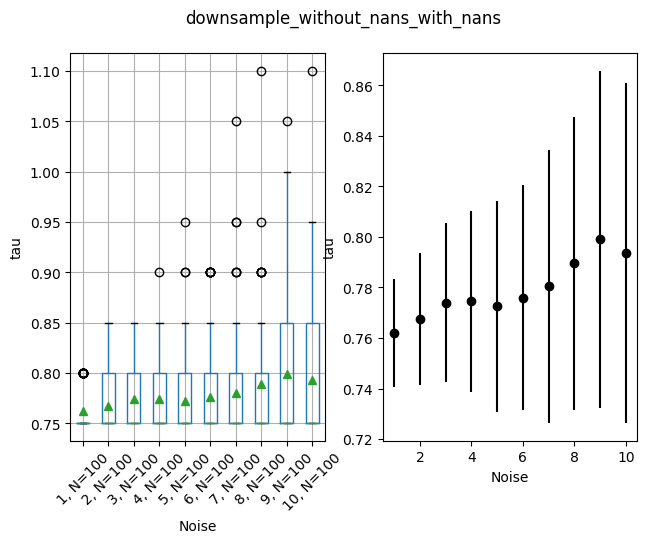

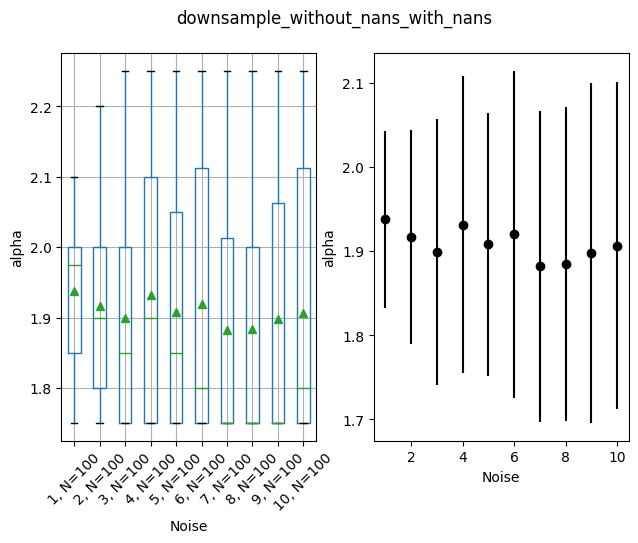

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau  \
0         1        41    0.943805  2.1500000000000012  0.75   
1         1        43    0.981642  2.1500000000000012  0.75   
2         1        61    0.874718  2.1500000000000012  0.75   
3         1        94    0.999317  2.1500000000000012  0.75   
4         1        71    1.033076  2.1500000000000012  0.75   
...     ...       ...         ...                 ...   ...   
2106     10        19  106.966580  2.5500000000000016  0.75   
2107     10        24   92.553864  2.5500000000000016   0.8   
2108     10        21   94.743353  2.6000000000000014  0.75   
2109     10        83   99.566072  2.6500000000000012  0.75   
2110     10        94   97.336033  2.6500000000000012  0.75   

                   alpha  
0     2.1500000000000004  
1     2.1500000000000004  
2     2.1500000000000004  
3     2.1500000000000004  
4                    2.2  
...                  ...  
2106                1.85  
2107                1.75  
2108                1.75  
2109                1.75  
2110                1.75  

[2111 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.59  0.621094  1.0  2.0  3.0  3.0  4.0
2                      100.0  2.54  0.657820  1.0  2.0  3.0  3.0  4.0
3                      100.0  2.37  0.883691  1.0  2.0  2.0  3.0  5.0
4                      100.0  2.31  0.991835  1.0  2.0  2.0  3.0  5.0
5                      100.0  2.14  0.921352  1.0  1.0  2.0  3.0  4.0
6                      100.0  2.05  1.085953  1.0  1.0  2.0  3.0  5.0
7                      100.0  1.74  0.883290  1.0  1.0  2.0  2.0  5.0
8                      100.0  1.92  0.981444  1.0  1.0  2.0  3.0  4.0
9                      100.0  1.72  0.995749  1.0  1.0  1.0  2.0  5.0
10                     100.0  1.73  0.897302  1.0  1.0  1.0  2.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
0         1        41    0.943805  2.1500000000000012  0.75   
1         1        43    0.981642  2.1500000000000012  0.75   
2         1        61    0.874718  2.1500000000000012  0.75   
3         1        94    0.999317  2.1500000000000012  0.75   
4         1        71    1.033076  2.1500000000000012  0.75   
...     ...       ...         ...                 ...   ...   
2103     10        19  106.966768  2.5000000000000013  0.75   
2106     10        19  106.966580  2.5500000000000016  0.75   
2108     10        21   94.743353  2.6000000000000014  0.75   
2109     10        83   99.566072  2.6500000000000012  0.75   
2110     10        94   97.336033  2.6500000000000012  0.75   

                   alpha  
0     2.1500000000000004  
1     2.1500000000000004  
2     2.1500000000000004  
3     2.1500000000000004  
4                    2.2  
...                  ...  
2103  1.9500000000000002  
2106                1.85  
2108                1.75  
2109                1.75  
2110                1.75  

[1185 rows x 6 columns]

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration       cost               delta   tau alpha
165       1         3   1.001514   2.300000000000001   0.8  1.75
166       1         4   1.023696   2.300000000000001   0.8  1.75
167       1         6   0.954710   2.300000000000001   0.8  1.75
168       1        12   0.958634   2.300000000000001   0.8  1.75
169       1        13   0.967549   2.300000000000001   0.8  1.75
...     ...       ...        ...                 ...   ...   ...
2105     10        80  96.392195  2.5000000000000013   0.8  1.75
2107     10        24  92.553864  2.5500000000000016   0.8  1.75
2108     10        21  94.743353  2.6000000000000014  0.75  1.75
2109     10        83  99.566072  2.6500000000000012  0.75  1.75
2110     10        94  97.336033  2.6500000000000012  0.75  1.75

[531 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
1        53      2   2.300000000000001   42    53      1   0.8   53
10       53     14  2.3500000000000014   11    53      5  0.75   29
2        54      4   2.300000000000001   26    54      3   0.8   48
3        52      6   2.300000000000001   22    52      3   0.8   34
4        43      7   2.250000000000001   15    43      4   0.8   18
5        45      8   2.300000000000001   10    45      4  0.75   19
6        50      9   2.300000000000001   11    50      4  0.75   21
7        61      9  2.4000000000000012   14    61      4  0.75   35
8        61     11  2.4000000000000012   12    61      5  0.75   24
9        59     14   2.300000000000001   12    59      6  0.75   31

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta   tau  \
260       2        87    3.946912   2.100000000000001  0.75   
513       3         4    9.701713  2.0500000000000007  0.75   
514       3        56    8.286917  2.0500000000000007  0.75   
515       3        73    8.968221  2.0500000000000007  0.75   
516       3        96    7.945506  2.0500000000000007  0.75   
...     ...       ...         ...                 ...   ...   
1987     10        90  103.976025   2.100000000000001  0.75   
1991     10        10  102.619924   2.100000000000001   0.8   
2004     10        48  107.216677  2.1500000000000012  0.75   
2005     10        77  106.916206  2.1500000000000012  0.75   
2030     10        40   99.979682   2.200000000000001  0.75   

                   alpha  
260   2.2500000000000004  
513   2.2500000000000004  
514   2.2500000000000004  
515   2.2500000000000004  
516   2.2500000000000004  
...                  ...  
1987  2.2500000000000004  
1991  2.2500000000000004  
2004  2.2500000000000004  
2005  2.2500000000000004  
2030  2.2500000000000004  

[143 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
10       23     11  1.9500000000000008    4    23      4  0.75   12
2         1      1   2.100000000000001    1     1      1  0.75    1
3        15      3   2.100000000000001    9    15      1  0.75   15
4        13      5   2.100000000000001    6    13      2  0.75   12
5        11      6   2.100000000000001    3    11      2  0.75    9
6        19      8  2.0500000000000007    5    19      3  0.75   15
7        14      4   2.100000000000001    8    14      2  0.75   11
8        22      9  1.9500000000000008    5    22      3  0.75   12
9        25     10  2.0500000000000007    4    25      4  0.75   13

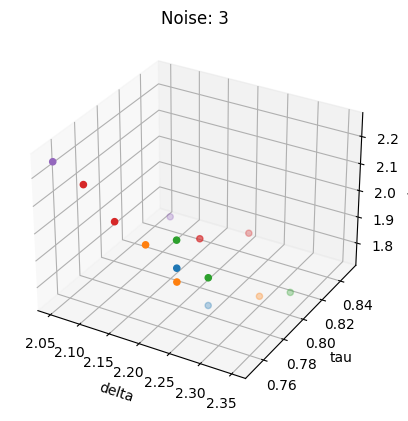

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

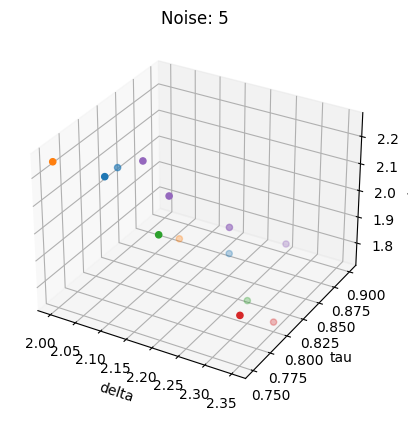

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

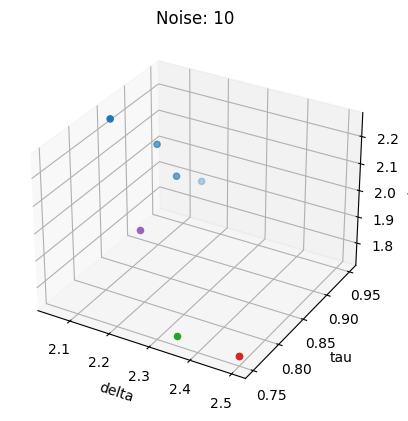

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta   tau  \
0         1        28    1.003723  2.1500000000000012  0.75   
1         1        42    1.011562  2.1500000000000012  0.75   
2         1        61    0.897628  2.1500000000000012  0.75   
3         1        81    0.960802  2.1500000000000012  0.75   
4         1        94    1.021457  2.1500000000000012  0.75   
...     ...       ...         ...                 ...   ...   
2090     10        47   97.731944  2.5500000000000016  0.75   
2091     10        24   97.558094  2.6000000000000014   0.8   
2092     10        19  105.393448  2.6500000000000012  0.75   
2093     10        21   98.856533  2.6500000000000012  0.75   
2094     10        94   95.972132  2.6500000000000012  0.75   

                   alpha  
0     2.1500000000000004  
1     2.1500000000000004  
2     2.1500000000000004  
3     2.1500000000000004  
4     2.1500000000000004  
...                  ...  
2090                 1.8  
2091                1.75  
2092                1.75  
2093                1.75  
2094                1.75  

[2095 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  2.70  0.627646  1.0  2.0  3.0  3.0  4.0
2                      100.0  2.49  0.810225  1.0  2.0  3.0  3.0  5.0
3                      100.0  2.44  1.076095  1.0  2.0  2.0  3.0  5.0
4                      100.0  2.34  1.017225  1.0  2.0  2.0  3.0  5.0
5                      100.0  2.13  0.981187  1.0  1.0  2.0  3.0  5.0
6                      100.0  1.94  1.023166  1.0  1.0  2.0  3.0  5.0
7                      100.0  1.72  1.005842  1.0  1.0  1.0  2.0  5.0
8                      100.0  1.77  0.972916  1.0  1.0  1.0  3.0  4.0
9                      100.0  1.73  1.043063  1.0  1.0  1.0  2.0  5.0
10                     100.0  1.69  0.960797  1.0  1.0  1.0  2.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

noise iteration        cost               delta   tau  \
0         1        28    1.003723  2.1500000000000012  0.75   
1         1        42    1.011562  2.1500000000000012  0.75   
2         1        61    0.897628  2.1500000000000012  0.75   
3         1        81    0.960802  2.1500000000000012  0.75   
4         1        94    1.021457  2.1500000000000012  0.75   
...     ...       ...         ...                 ...   ...   
2089     10        60   87.473881  2.5500000000000016  0.75   
2090     10        47   97.731944  2.5500000000000016  0.75   
2092     10        19  105.393448  2.6500000000000012  0.75   
2093     10        21   98.856533  2.6500000000000012  0.75   
2094     10        94   95.972132  2.6500000000000012  0.75   

                   alpha  
0     2.1500000000000004  
1     2.1500000000000004  
2     2.1500000000000004  
3     2.1500000000000004  
4     2.1500000000000004  
...                  ...  
2089                1.75  
2090                 1.8  
2092                1.75  
2093                1.75  
2094                1.75  

[1150 rows x 6 columns]

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta   tau alpha
173       1         4    1.054783   2.300000000000001   0.8  1.75
174       1         7    0.939086   2.300000000000001   0.8  1.75
175       1        12    0.980780   2.300000000000001   0.8  1.75
176       1        14    0.967398   2.300000000000001   0.8  1.75
177       1        17    0.969081   2.300000000000001   0.8  1.75
...     ...       ...         ...                 ...   ...   ...
2089     10        60   87.473881  2.5500000000000016  0.75  1.75
2091     10        24   97.558094  2.6000000000000014   0.8  1.75
2092     10        19  105.393448  2.6500000000000012  0.75  1.75
2093     10        21   98.856533  2.6500000000000012  0.75  1.75
2094     10        94   95.972132  2.6500000000000012  0.75  1.75

[517 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
1        52      2   2.300000000000001   39    52      1   0.8   52
10       58     15   2.450000000000001    9    58      7  0.75   33
2        39      4   2.300000000000001   17    39      3   0.8   34
3        50      6  2.4000000000000012   14    50      4   0.8   23
4        47      9   2.300000000000001   17    47      4   0.8   22
5        42     10  2.4000000000000012   13    42      4   0.8   16
6        52     10   2.300000000000001    9    52      4  0.75   23
7        55     11  2.4000000000000012   12    55      6  0.75   35
8        59     12  2.3500000000000014   12    59      6  0.75   28
9        63     14   2.300000000000001   11    63      7  0.75   29

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta   tau  \
270       2        62    3.812045  2.0500000000000007  0.75   
271       2        76    4.077495  2.0500000000000007  0.75   
276       2        87    4.080057   2.100000000000001  0.75   
295       2        95    4.140532  2.1500000000000012  0.75   
521       3        73    9.031664  2.0500000000000007  0.75   
...     ...       ...         ...                 ...   ...   
1962     10        31   95.563221  2.0500000000000007  0.75   
1963     10        37   97.923716  2.0500000000000007  0.75   
1964     10        81  111.223773  2.0500000000000007  0.75   
1966     10        61  105.203661  2.0500000000000007   0.8   
1993     10        61  105.207504  2.1500000000000012  0.75   

                   alpha  
270   2.2500000000000004  
271   2.2500000000000004  
276   2.2500000000000004  
295   2.2500000000000004  
521   2.2500000000000004  
...                  ...  
1962  2.2500000000000004  
1963  2.2500000000000004  
1964  2.2500000000000004  
1966  2.2500000000000004  
1993  2.2500000000000004  

[137 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                  
      count unique                 top freq count unique   top freq
noise                                                              
10       18      9  2.0500000000000007    4    18      4  0.75    6
2         4      3  2.0500000000000007    2     4      1  0.75    4
3        13      3   2.100000000000001    9    13      1  0.75   13
4        15      6   2.000000000000001    4    15      2  0.75   11
5        10      7  2.0500000000000007    3    10      2  0.75    9
6        17      6   2.000000000000001    5    17      2  0.75   12
7        18      9  2.1500000000000012    4    18      4  0.75   12
8        17     10  1.9500000000000008    3    17      4   0.8    7
9        25     12  1.9000000000000008    5    25      3  0.75    9

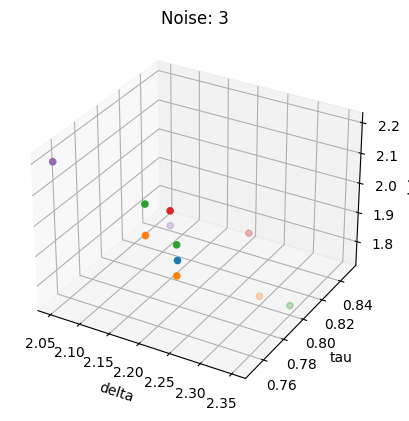

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

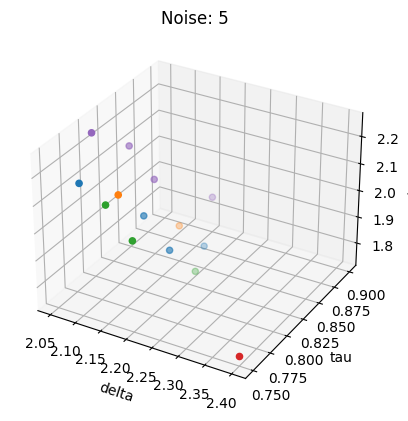

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()